<a href="https://colab.research.google.com/github/V-AISHVARYA/LGMVIP-Datascience-Task-10/blob/main/ML_FACIAL_RECOGNITION_RECOGNITION_TO_DETECT_MOOD_AND_SUGGEST_SONGS__ACCORDINGLY_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**LGMVIP TASK10**:
**ML Facial recognition to detect mood and suggest songs accordingly**  
To detect emotions from face and suggest songs accordingly.

~Aishvarya.V

##### IMPORT LIBRARIES

In [1]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.12.0
Num GPUs Available:  0


##### LOADING THE DATASET

In [3]:
! pip install -q kaggle

In [4]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aishvaryav","key":"da980353f70ec43ae9edc9bab769cc89"}'}

In [5]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [6]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [7]:
 ! kaggle datasets list

ref                                                 title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023     Global YouTube Statistics 2023                  60KB  2023-07-28 15:36:38          10964        371  1.0              
nelgiriyewithana/top-spotify-songs-2023             Most Streamed Spotify Songs 2023                47KB  2023-08-26 11:04:57           1233         57  1.0              
ravindrasinghrana/employeedataset                   Employee Dataset(All in One)                   520KB  2023-08-13 08:06:29           1223         34  1.0              
arjunajn/netflix-watch-log                          Netflix Watch Log                              295KB  2023-08-22 08:23:45            894     

In [8]:
! kaggle competitions download -c 'FER-2013'

403 - Forbidden - Permission 'competitions.participate' was denied


In [9]:
! mkdir facerecogmusicrecommend

In [10]:
! unzip train.zip -d facerecogmusicrecommend

unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.


In [11]:
! mkdir kaggle_data
! unzip {FER-2013+ "train.zip"} -d kaggle_data

unzip:  cannot find or open {FER-2013+, {FER-2013+.zip or {FER-2013+.ZIP.


In [12]:
!kaggle datasets list

ref                                                 title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023     Global YouTube Statistics 2023                  60KB  2023-07-28 15:36:38          10964        371  1.0              
nelgiriyewithana/top-spotify-songs-2023             Most Streamed Spotify Songs 2023                47KB  2023-08-26 11:04:57           1233         57  1.0              
ravindrasinghrana/employeedataset                   Employee Dataset(All in One)                   520KB  2023-08-13 08:06:29           1223         34  1.0              
arjunajn/netflix-watch-log                          Netflix Watch Log                              295KB  2023-08-22 08:23:45            894     

In [13]:
!kaggle datasets download -d msambare/fer2013

 81% 49.0M/60.3M [00:00<00:00, 74.1MB/s]
100% 60.3M/60.3M [00:00<00:00, 93.0MB/s]


In [14]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [15]:
train_dir ='/content/train'
test_dir = '/content/test'
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       fear  neutral  surprise  disgust   sad  happy  angry
train  4097     4965      3171      436  4830   7215   3995
      fear  neutral  surprise  disgust   sad  happy  angry
test  1024     1233       831      111  1247   1774    958


##### DATA VISUALIZATION

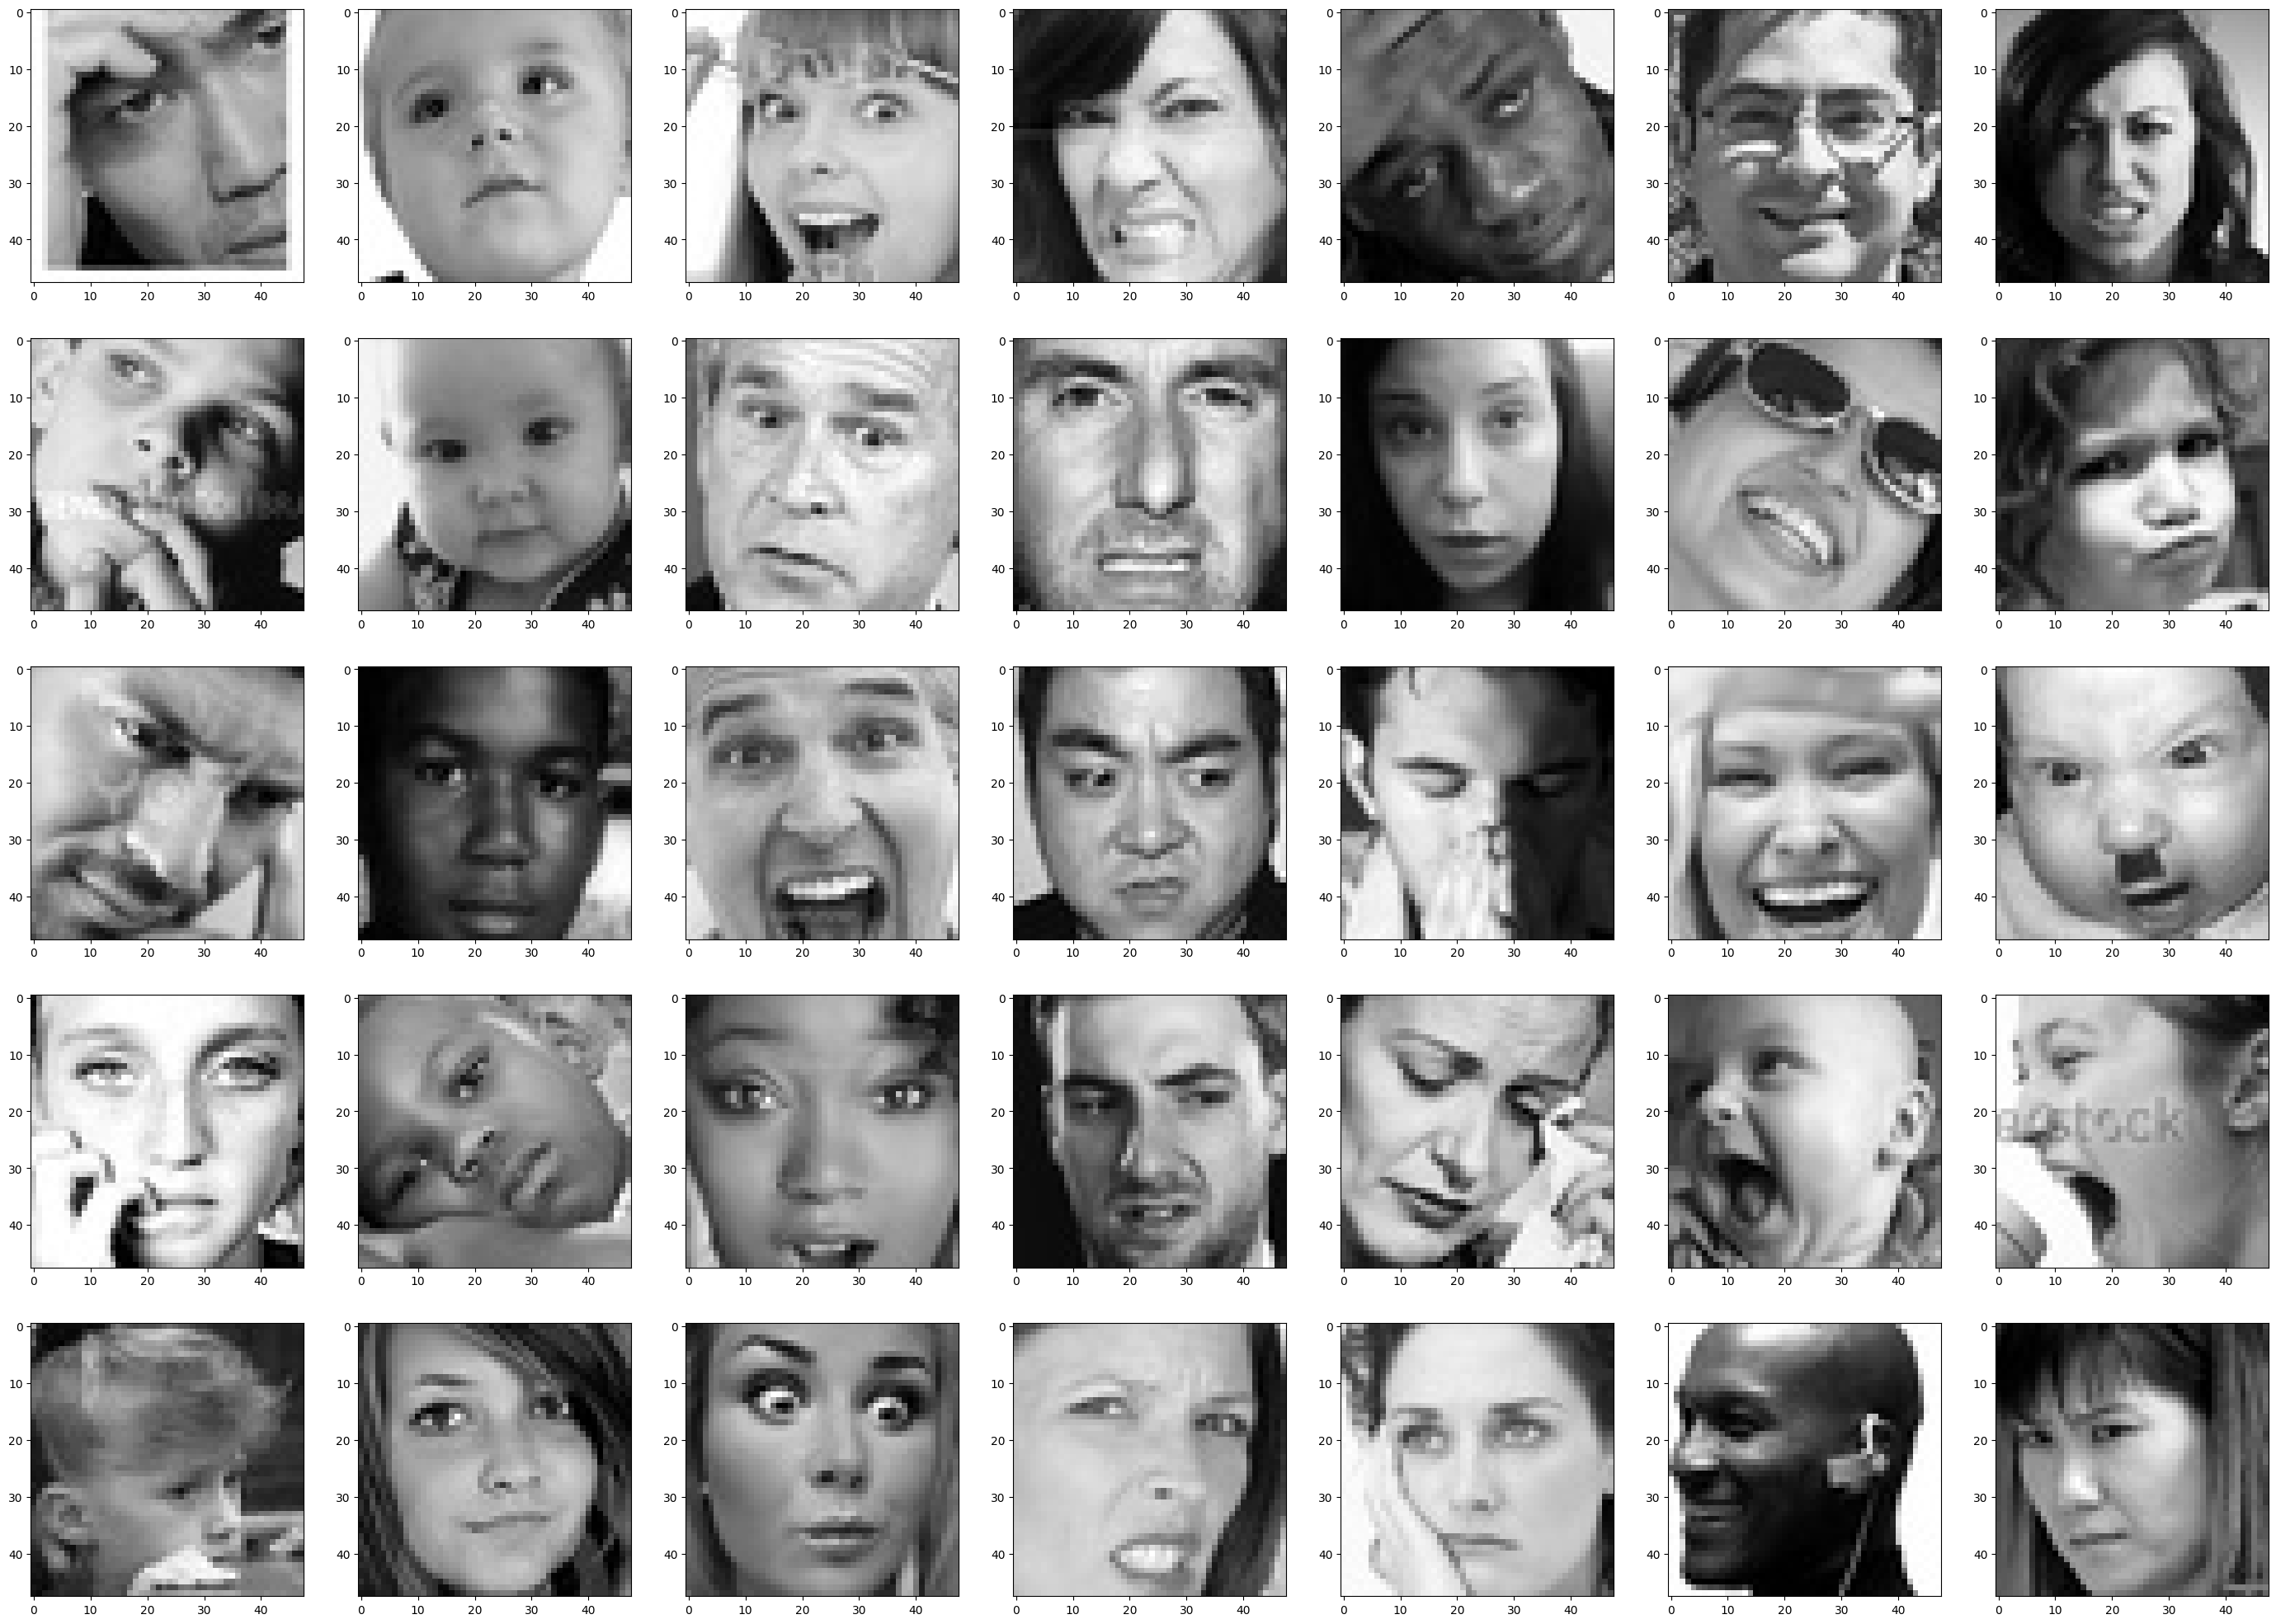

In [16]:
from skimage.io import imread
train_dir = "/content/train/"
test_dir = "/content/test/"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

##### PLOT THE GRAPH

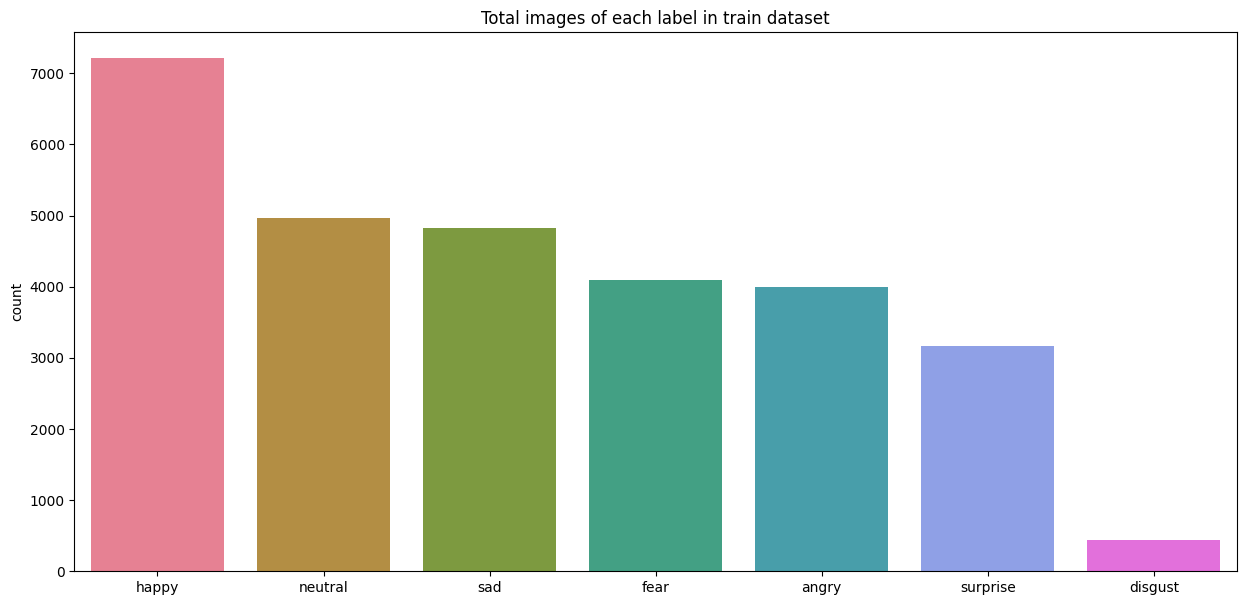

In [17]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="husl", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

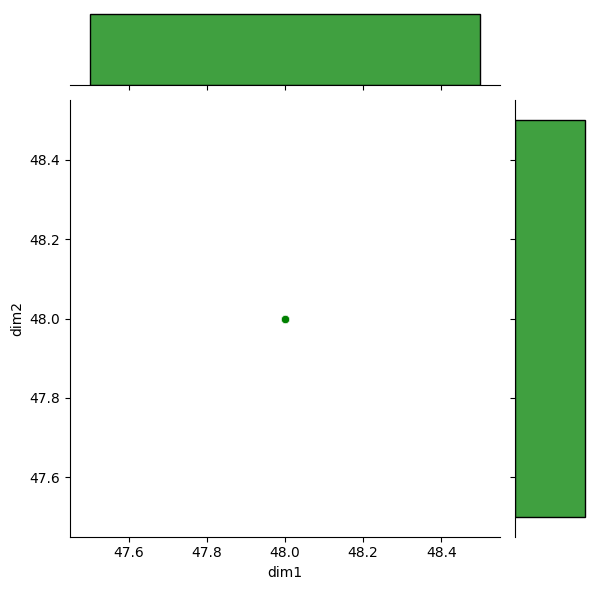

In [18]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

df = pd.DataFrame({'dim1': dim1, 'dim2': dim2})
sns.jointplot(data=df, x='dim1', y='dim2', color='g')
plt.show()

##### DATA PREPROCESSING

In [19]:
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


##### BUILD THE MODEL

In [20]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

##### TRAIN THE MODEL

In [21]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [22]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 5

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,

                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/5
448/448 [==============================] - 818s 2s/step - loss: 1.9398 - accuracy: 0.2290 - val_loss: 2.0717 - val_accuracy: 0.2473
Epoch 2/5
448/448 [==============================] - 855s 2s/step - loss: 1.8147 - accuracy: 0.2478 - val_loss: 1.8159 - val_accuracy: 0.2461
Epoch 3/5
448/448 [==============================] - 854s 2s/step - loss: 1.8132 - accuracy: 0.2498 - val_loss: 1.8126 - val_accuracy: 0.2473
Epoch 4/5
448/448 [==============================] - 816s 2s/step - loss: 1.8113 - accuracy: 0.2512 - val_loss: 1.8133 - val_accuracy: 0.2475
Epoch 5/5
448/448 [==============================] - 849s 2s/step - loss: 1.8112 - accuracy: 0.2511 - val_loss: 1.8130 - val_accuracy: 0.2475


In [23]:
model.save("model.h5")

##### EVALUATE THE MODEL

In [24]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 43s 384ms/step - loss: 1.8134 - accuracy: 0.2471
validation accuracy : 24.714405834674835%
validation loss : 1.8134280443191528


##### TRAIN AND VALIDATION

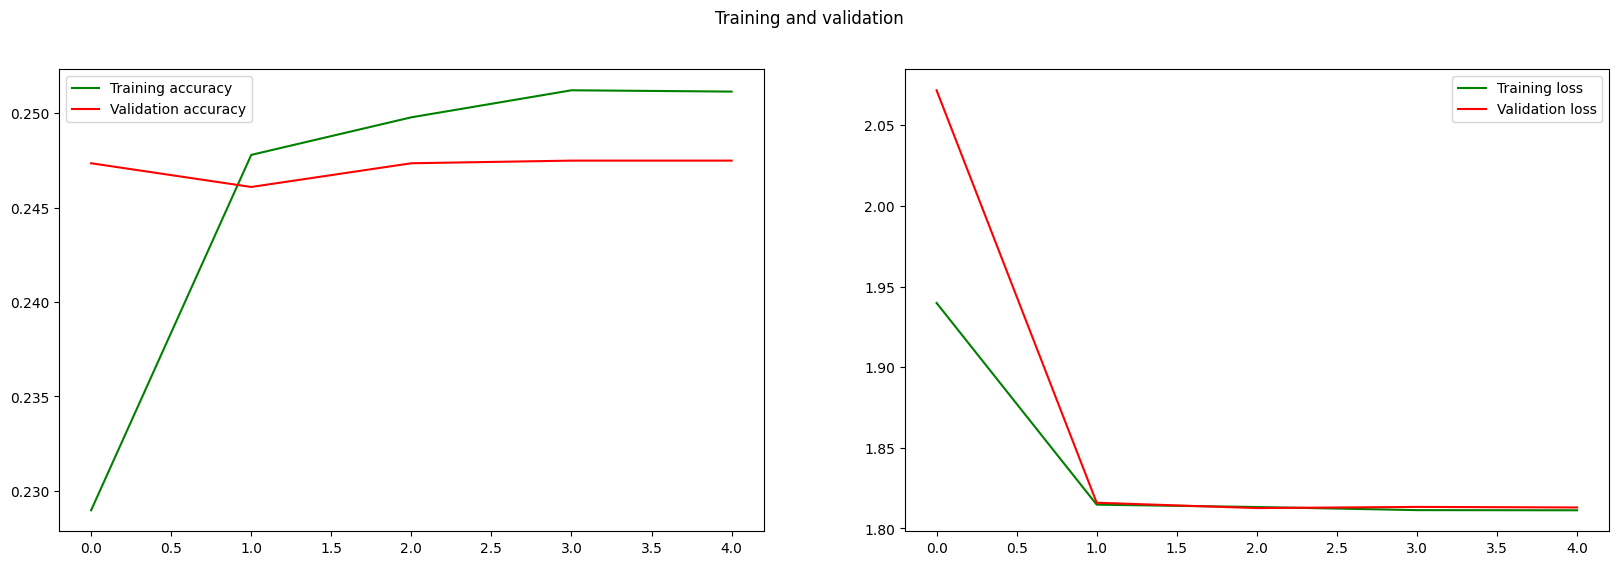

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 43s 383ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178





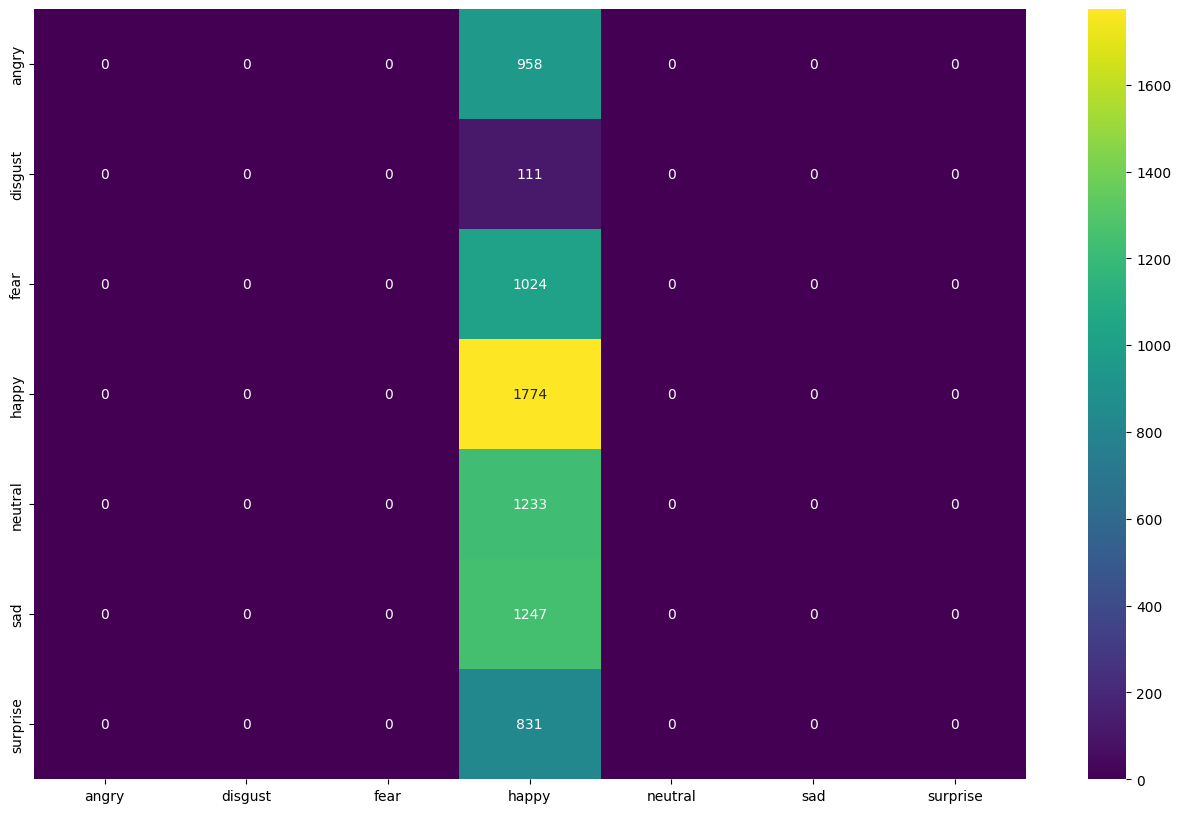

In [26]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

##### TEST MODEL WITH NEW IMAGE

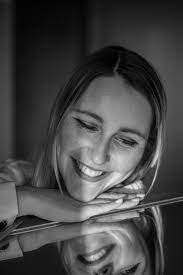

In [27]:
image = cv2.imread("/content/greyscale.jpeg")
from IPython.display import Image
Image(filename='/content/greyscale.jpeg')

In [28]:
import cv2
from tensorflow.python.keras.models import load_model
import os

# Load the trained model
model = tf.keras.models.load_model("model.h5",
                                   custom_objects={'Functional': tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, convert to grayscale, and normalize
frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_LINEAR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reshape the image dimension
gray = gray.reshape(1, 48, 48, 1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i, j) in zip(range(7), EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j) + " prediction rate is   {0:.2f}%".format(predictss))
print("\n\n The system considers this expression to be:", label)

1/1 [==============================] - 0s 112ms/step
  Angry    prediction rate is   0.14%
 Disgust   prediction rate is   0.01%
  Happy    prediction rate is   0.15%
   Sad     prediction rate is   0.24%
 Surprise  prediction rate is   0.17%
 Neutral   prediction rate is   0.17%


 The system considers this expression to be: Sad


In [34]:
import random
from IPython.display import Audio, display

if label == 'Angry':
    path = "/content/angry.mp3"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='/content/angry.mp3' + d, autoplay=True)
    display(audio)

elif label == 'Disgust':
    path = "/content/Years Of Disgust.mp3"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='/content/Years Of Disgust.mp3' + d, autoplay=True)
    display(audio)

elif label == "Happy":
    path = "/content/Happy Happy Happy Happy Happy.mp3"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='/content/Happy Happy Happy Happy Happy.mp3' + d, autoplay=True)
    display(audio)

elif label == 'sad':
    path = "/content/sad.mp3"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='/content/sad.mp3' + d, autoplay=True)
    display(audio)

elif label == 'Surprise':
    path = "/content/Surprise Bags.mp3"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='/content/Surprise Bags.mp3' + d, autoplay=True)
    display(audio)

elif label == 'Neutral':
    path = "/content/Tamil Tamil.mp3"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename='/content/Tamil Tamil.mp3' + d, autoplay=True)
    display(audio)